In [1]:
!pip3 install --upgrade --quiet tensorflow-gpu
!pip install --upgrade --quiet PyDrive
!pip install -U tensorboardcolab
!pip install svgwrite



%tensorflow_version 2.x

!pip install --upgrade --quiet tensorflow==2.0.0b1
!pip install --upgrade --quiet tensorflow-gpu==2.0.0b1
!pip install --quiet keras==2.3.1
!pip install --upgrade --quiet PyDrive
!pip install -U tensorboardcolab
!pip install svgwrite

import tensorflow as tf

     |████████████████████████████████| 320.4MB 51kB/s 
Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)
     |████████████████████████████████| 71kB 4.4MB/s 
     |████████████████████████████████| 87.9MB 1.2MB/s 
     |████████████████████████████████| 501kB 52.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 3.1MB 54.8MB/s 
     |████████████████████████████████| 348.9MB 22kB/s 
     |████████████████████████████████| 378kB 9.1MB/s 
Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
!git clone https://github.com/MarioBonse/Sketch-rnn.git
import os
os.chdir("Sketch-rnn")

Cloning into 'Sketch-rnn'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 285 (delta 40), reused 45 (delta 5), pack-reused 182
Receiving objects: 100% (285/285), 368.02 MiB | 25.86 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [3]:
import data_Manager 
from HyperParameters import HP
import keras
import matplotlib.pyplot as plt
from train import *
from tensorboardcolab import *
import draw

#tbc=TensorBoardColab()
HP.data_folder = "data/"
HP.data_name = "carrot.npz"
HP.data_location = "data/carrot.npz"
datas = data_Manager.Data()

# create the callback for data augmentaion during training
train_generator = data_Manager.DataGenerator(datas.train)
validation_encoder = datas.valid
validation_decoder = data_Manager.create_decoder_input(validation_encoder)
vaidation = [validation_encoder, validation_decoder]
HP.epochs = 10




Using TensorFlow backend.


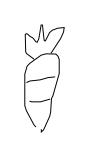

In [4]:
draw.draw_strokes(datas.train[0], svg_filename="carrot.svg")

In [5]:

"""
Create the model

1. ENCODER
"""
encoder_input = tf.keras.layers.Input(batch_shape = (HP.batch_size, None, HP.input_dimention), name = "encoder_input" )

encoderLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP.enc_hidden_size, return_sequences=False,
    recurrent_dropout=HP.rec_dropout, name = "LSTM_encoder"), merge_mode='concat', name = "BI_LSTM_encoder")(encoder_input)

hidden_state_mean = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "mean_MLP")(encoderLSTM)

variance_hat = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "variance_MLP")(encoderLSTM)

# from mean and variance to latent vairable z
z = tf.keras.layers.Lambda(sampling, output_shape=(HP.latent_dim,), name='z')([hidden_state_mean, variance_hat])

# create the model with keras
encoder = tf.keras.models.Model(encoder_input, [hidden_state_mean, variance_hat, z], name='encoder')
encoder.summary()
#tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

""" 
DECODER 
"""
# the decoder LSTM has an input composed by the sequence and also the hidden state
decoder_input_sequence = tf.keras.layers.Input(batch_shape = (HP.batch_size, HP.max_seq_length, HP.input_dimention), name = "decoder_seq_input" )
# we have also the latent variable as input of the LSTM with the sequence
inputLatentVariable = tf.keras.layers.RepeatVector(HP.max_seq_length)(z)
# so we concatentate the two vector
# as input we have the two vector above concatenated
totalInput = tf.keras.layers.Concatenate()([decoder_input_sequence, inputLatentVariable])
# Create LSTM for generation with input state = tanh(z)
decoderLSTM = tf.keras.layers.LSTM(HP.dec_hidden_size, recurrent_dropout=HP.rec_dropout, 
                                    return_sequences=True, return_state=True, name = "LSTM_decoder")
#
init_state = tf.keras.layers.Dense(units=(2*decoderLSTM.units), activation='tanh', name = "decoder_init_stat")(z)
h_0, c_0 = tf.split(init_state, num_or_size_splits=2, axis = 1)

# creation of the LSTM
decoder_output, _, _ = decoderLSTM(totalInput, initial_state = [h_0, c_0])

# dense to output. THe dimention is, as explained in the paper equal to 3 + 6*M
# 6 times M= number of mixture 
output_dimention = (3 + HP.M * 6)
distribution_output = tf.keras.layers.Dense(output_dimention, name = "output_layer")(decoder_output)

# Build Keras model
seq_to_seq_VAE = tf.keras.models.Model([encoder_input, decoder_input_sequence], distribution_output)
seq_to_seq_VAE.summary()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(100, None, 5)]     0                                            
__________________________________________________________________________________________________
BI_LSTM_encoder (Bidirectional) (100, 512)           536576      encoder_input[0][0]              
__________________________________________________________________________________________________
mean_MLP (Dense)                (100, 256)           131328      BI_LSTM_encoder[0][0]            
__________________________________________________________________________________________________
variance_MLP (Dense)            (100, 256)           131328      BI_LSTM_encoder[0][0]            
____________________________________________________________________________________________

Define the loss

In [6]:
    KL_weight = tf.keras.backend.variable(0.01, name = 'kl_weight')
    KL_wheight_schedule = data_Manager.changing_KL_wheight(KL_weight)
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # E[log P(X|z)]
        recon = reconstruction_loss(y_true, y_pred)
        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl = kl_loss(hidden_state_mean, variance_hat)

        return recon + kl*KL_weight

In [7]:
optimizer = tf.keras.optimizers.Adam(lr = HP.lr, clipvalue= HP.grad_clip)
seq_to_seq_VAE.compile(optimizer=optimizer,  loss = vae_loss)


In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
with tf.device('/device:GPU:0'):
  history = seq_to_seq_VAE.fit_generator(train_generator,
                       validation_data= ([validation_encoder, validation_decoder],[validation_encoder]),
                       steps_per_epoch=(datas.trainDimention)/HP.batch_size, 
                       epochs=HP.epochs, 
                       callbacks=[KL_wheight_schedule])
# save the model
seq_to_seq_VAE.save_weights("model_weight_carrot_20_epochs.h5")

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
700/700 [==============================] - 737s 1s/step - loss: 0.8061 - val_loss: 0.6546
Epoch 2/10
700/700 [==============================] - 738s 1s/step - loss: 0.6163 - val_loss: 0.5959
Epoch 3/10
700/700 [==============================] - 738s 1s/step - loss: 0.5790 - val_loss: 0.5700
Epoch 4/10
700/700 [==============================] - 734s 1s/step - loss: 0.5581 - val_loss: 0.5527
Epoch 5/10
700/700 [==============================] - 732s 1s/step - loss: 0.5429 - val_loss: 0.5400
Epoch 6/10
700/700 [==============================] - 731s 1s/step - loss: 0.5316 - val_loss: 0.5307
Epoch 7/10
700/700 [==============================] - 730s 1s/step - loss: 0.5230 - val_loss: 0.5235
Epoch 8/10
700/700 [==============================] - 731s 1s/step - loss: 0.5186 - val_loss: 0.5196
Epoch 9/10
700/700 [==============================] - 728s 1s/step - loss: 0.5120 - val_loss: 0.51

Plot the history

dict_keys(['loss', 'val_loss'])


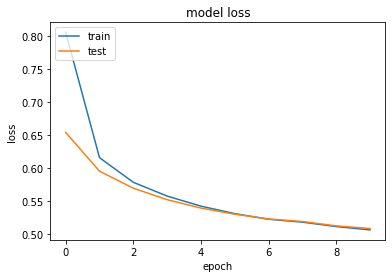

In [10]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
seq_to_seq_VAE.load_weights("model_weight_carrot_20_epochs.h5", by_name = True)


In [22]:
HP.epocs = 20
with tf.device('/device:GPU:0'):
  history = seq_to_seq_VAE.fit_generator(train_generator,
                       validation_data= ([validation_encoder, validation_decoder],[validation_encoder]),
                       steps_per_epoch=(datas.trainDimention)/HP.batch_size, 
                       epochs=20, 
                       callbacks=[KL_wheight_schedule], initial_epoch = 10)
# save the model
seq_to_seq_VAE.save_weights("model_weight_carrot_50_epochs.h5")


Epoch 11/20
700/700 [==============================] - 765s 1s/step - loss: 0.5030 - val_loss: 0.5064
Epoch 12/20
700/700 [==============================] - 755s 1s/step - loss: 0.4997 - val_loss: 0.5033
Epoch 13/20
700/700 [==============================] - 738s 1s/step - loss: 0.4967 - val_loss: 0.4996
Epoch 14/20
700/700 [==============================] - 735s 1s/step - loss: 0.4938 - val_loss: 0.4979
Epoch 15/20
700/700 [==============================] - 730s 1s/step - loss: 0.4916 - val_loss: 0.4954
Epoch 16/20
700/700 [==============================] - 730s 1s/step - loss: 0.4893 - val_loss: 0.4941
Epoch 17/20
700/700 [==============================] - 733s 1s/step - loss: 0.4875 - val_loss: 0.4928
Epoch 18/20
700/700 [==============================] - 729s 1s/step - loss: 0.4857 - val_loss: 0.4916
Epoch 19/20
700/700 [==============================] - 729s 1s/step - loss: 0.4841 - val_loss: 0.4907
Epoch 20/20
700/700 [==============================] - 733s 1s/step - loss: 0.4827

dict_keys(['loss', 'val_loss'])


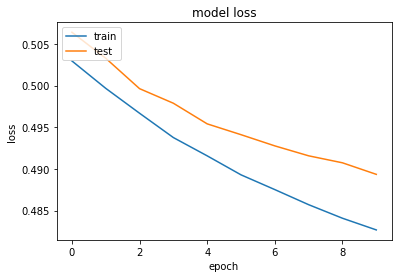

In [23]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()